<h1> all code <h1>


## Task 1: import all packeges that we need

In [1]:
import itertools
import cv2
import os
import time

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras

from tensorflow.keras.applications.efficientnet import EfficientNetB7  as PretrainedModel, preprocess_input
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from glob import glob

## Task 2 : Dataset in local || Path - count of images


In [2]:


# Define the local path to the dataset
local_dataset_path = 'archive/lung_colon_image_set/'

# Get a list of folders in the specified directory
local_folders = glob(local_dataset_path + '*')
print('Local Paths: ', local_folders)

# Get a list of image files in the specified subdirectory
LOCAL_IMAGE_FILES = glob(local_dataset_path + 'lung_image_sets/*/*.jpeg')
print('Local Images Count: ', len(LOCAL_IMAGE_FILES))

Local Paths:  ['archive/lung_colon_image_set\\colon_image_sets', 'archive/lung_colon_image_set\\lung_image_sets']
Local Images Count:  15000


## Task 3 : take samples from dataset

<Figure size 2500x1000 with 0 Axes>

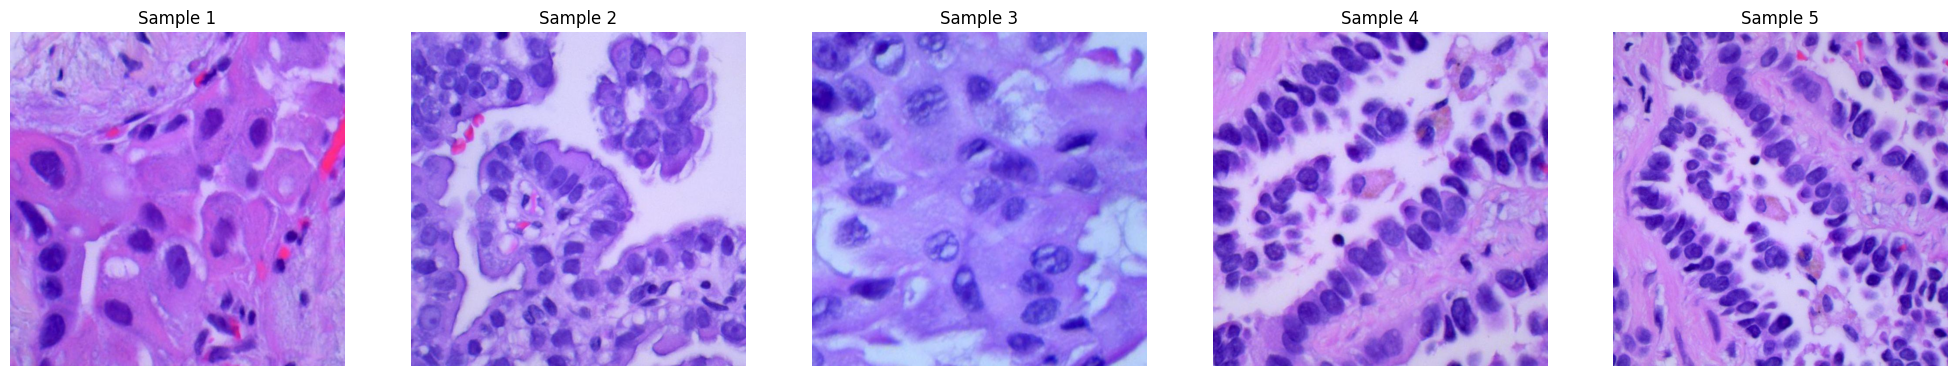

In [3]:
from matplotlib.image import imread
SAMPLES = ["archive/lung_colon_image_set/lung_image_sets/lung_aca/lungaca1.jpeg",

           'archive/lung_colon_image_set/lung_image_sets/lung_aca/lungaca10.jpeg', 
           'archive/lung_colon_image_set/lung_image_sets/lung_aca/lungaca1000.jpeg',

           'archive/lung_colon_image_set/lung_image_sets/lung_aca/lungaca1006.jpeg', 
           'archive/lung_colon_image_set/lung_image_sets/lung_aca/lungaca1007.jpeg']

plt.figure(figsize=(25, 10)) 

# Create a subplot for each image
fig, axes = plt.subplots(1, len(SAMPLES), figsize=(25, 10))

# Iterate through the images and display them
for i, sample_path in enumerate(SAMPLES):
    # Read the image
    img = imread(sample_path)

    # Display the image
    axes[i].imshow(img)
    axes[i].axis("off")  
    axes[i].set_title(f"Sample {i + 1}")

# Show the plot
plt.show()

## Task 4: take another samples from dataset 

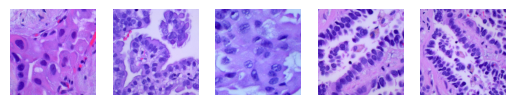

In [4]:
global c
c = 0

for i in SAMPLES:
    plt.subplot(1, 5, c + 1)
    c += 1
    t = i.split('/')
    plt.imshow(image.load_img(i))
    plt.axis('off')
    
plt.show()

## Task 5 : training and validation

In [5]:

data_dir = 'archive/lung_colon_image_set/lung_image_sets'

# 80-20 Split
data = ImageDataGenerator(validation_split = 0.2)

BATCH_SIZE = 128

# 224 x 224 -- The minimum for EfficientNetB7, you can go as high as 600 x 600
X = Y = 299

training = data.flow_from_directory(data_dir,
                                    class_mode = "categorical",
                                    target_size = (X, Y),
                                    color_mode="rgb",
                                    batch_size = BATCH_SIZE, 
                                    shuffle = False,
                                    subset='training',
                                    seed = 42)

validation = data.flow_from_directory(data_dir,
                                      class_mode = "categorical",
                                      target_size = (X, Y),
                                      color_mode="rgb",
                                      batch_size = BATCH_SIZE, 
                                      shuffle = False,
                                      subset='validation',
                                      seed = 42)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


## Task 6 : base_model || inception_v3

In [24]:

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
])
# Specify the local path to the downloaded weights file
local_weights_path = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

IMG_SHAPE = (X,Y) +(3,)
#base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top= False,weights='imagenet')
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top= False,weights=None)
base_model.load_weights(local_weights_path)
type(base_model)
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

nb_layers = len(base_model.layers)
print("Numbers of Layers =" , nb_layers)
print(base_model.layers[nb_layers - 2].name)  # pre- Last name
print(base_model.layers[nb_layers - 1].name) 

Numbers of Layers = 311
activation_281
mixed10


## task 7

In [25]:

# iterate over first batch (32 image) in trainset 
image_batch, label_batch = next(iter(training))  # 32 image arrays
feature_batch = base_model(image_batch)  # run the model on those 32 image (base model with its 1000 causes classification)
print(feature_batch.shape)  # 32 for number of images in this batch and 1000 for classes


(128, 8, 8, 2048)


In [26]:
def ChestCancer_Model( image_shape=(X,Y)):
    ''' Define a tf.keras model for multi-class classification out of the InceptionV3 model '''
    image_shape = image_shape + (3,)
    
    resnet_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top= False,weights='imagenet')
    resnet_model.trainable = True
    for layer in resnet_model.layers[0 : 290]:
        layer.trainable = False
    
    inputs = tf.keras.Input(image_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(inputs)
    x = resnet_model(x , training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    prediction_layer = tf.keras.layers.Dense(3 ,activation = "softmax") 
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs) 
    model.summary()
    return model


In [40]:
from tensorflow.keras import layers, models
import keras 
from keras.callbacks import ModelCheckpoint
import datetime
import os
# Set up the logs directory
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
os.makedirs(log_dir, exist_ok=True)



# Assuming ChestCancer_Model is a Keras model instance
ChestCancer_Model = models.Sequential()  

base_learning_rate = 0.001
ChestCancer_Model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=base_learning_rate),
                           loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                           metrics=['accuracy' , tf.keras.metrics.Precision()])


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)


earlystop =tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=15, 
                          verbose=1, 
                          restore_best_weights=True)
                        
checkpoint=tf.keras.callbacks.ModelCheckpoint(
     './checkpoints', 
    verbose=1, 
    save_weights_only=True,
    save_best_only=True,
     save_freq='epoch'  # Updated to save at the end of each epoch
   # period=5
)
callback=[earlystop,checkpoint,tensorboard_callback]


# Updated usage with 'save_freq'
checkpoint_callback = ModelCheckpoint(filepath='model_weights.h5', save_freq='epoch', save_best_only=True)


train_log_dir = os.path.join(log_dir, 'train')
validation_log_dir = os.path.join(log_dir, 'validation')
os.makedirs(train_log_dir, exist_ok=True)
os.makedirs(validation_log_dir, exist_ok=True)


In [43]:
# Training the model
history = ChestCancer_Model.fit(training ,
                                    verbose=1 ,
                                    epochs=15,
                               validation_data=validation , use_multiprocessing= True, callbacks=callback)


FailedPreconditionError: {{function_node __wrapped__CreateSummaryFileWriter_device_/job:localhost/replica:0/task:0/device:CPU:0}} logs/fit/20240101_094023\train is not a directory [Op:CreateSummaryFileWriter] name: 

In [15]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)

plt.plot(acc, label='Training Accuracy', color='r')
plt.plot(val_acc, label='Validation Accuracy', color='b')


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('Training & Validation Acc.', fontsize=16, weight='bold')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='r')
plt.plot(val_loss, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')
plt.show()

NameError: name 'history' is not defined

In [12]:

from sklearn.metrics import classification_report

Y_pred = ChestCancer_Model.predict(validation)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(validation.classes, y_pred))


24/24 [==============================] - 290s 11s/step


In [ ]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=12, weight='bold',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16, weight='bold')
    plt.xlabel('Predicted label', fontsize=16, weight='bold')


In [ ]:

# Compute confusion matrix
cnf_matrix = confusion_matrix(validation.classes, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc'],normalize=True,
                      title='Normalized Confusion Matrix')
plt.show()
